# Why do we care about uncertainty?

- Softmax does not directly capture uncertainty
- Bayesian neural networks will provide a distribution over softmax outputs
- The softmax output is directly related to predictive uncertainty, but uncertainty can be further decomposed into *epistemic* and *aleatoric*
    - These types of uncertainties need to be handled differently -- epistemic can be reduced with more training data, aleatoric cannot
    - With only the softmax, we cannot distinguish between these two cases

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from numpy import ma
from keras.layers import Input
from toolbox import load_dataset
plt.style.use('ggplot')

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# dataset = 'mnist'
dataset = 'cifar10'
# dataset = 'svhn'

In [3]:
run = 1
file_name = '../../models/bbalpha/keras/saved_models/{}-cnn-alpha0.5-run{}/model-test.h5'.format(dataset, run)
test_model = load_model(file_name)

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
_, _, test = load_dataset.load_image_data(dataset, channels_first=False)

In [5]:
pred = test_model.predict(test[0])
nb_test = pred.shape[1]
n = pred.shape[0]
nb_classes = pred.shape[2]

In [6]:
avg_pc = np.mean(pred, axis=1)  #integrate over weight samples

In [7]:
test_acc = (np.argmax(avg_pc, axis=-1) == np.argmax(test[1], axis=-1))
np.mean(test_acc)

0.715

In [8]:
predictive = - np.sum(avg_pc * ma.log2(avg_pc).filled(0), axis=-1)

In [9]:
aleatoric = - 1/nb_test * np.sum(pred * ma.log2(pred).filled(0), axis=(1,2))

In [10]:
epistemic = predictive - aleatoric

## Plot max softmax vs uncertainty

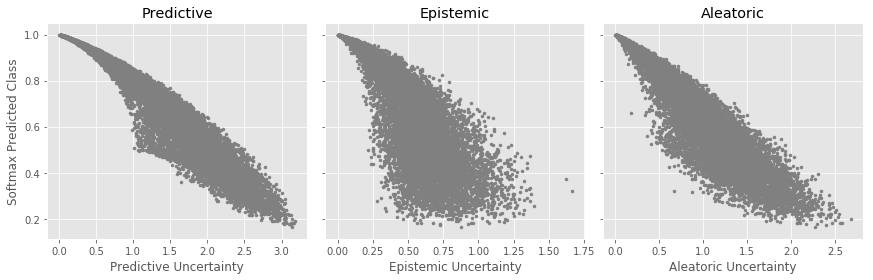

In [11]:
max_softmax = np.max(avg_pc, axis=1)
uncertainties = [predictive, epistemic, aleatoric]
titles = ['Predictive','Epistemic', 'Aleatoric']
f, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for (ax, uncertainty, title) in zip(axes, uncertainties, titles):
    ax.scatter(uncertainty, max_softmax, color=[0.5, 0.5, 0.5], marker='.')
    ax.set_title(title)
    ax.set_xlabel('{} Uncertainty'.format(title))
f.tight_layout()
axes[0].set_ylabel('Softmax Predicted Class')
f.savefig('{}.png'.format(dataset), format='png', dpi=600, bbox_inches='tight')